# 1.7f: Perturbation Test (Float32)

This notebook is identical to 1.7e except we compute logits in **float32** instead of bfloat16.

## The Question

In 1.7e, we found that even when pointing almost exactly at the cluster centroid (cosine sim 0.9998), the cluster is **completely indistinguishable** in bfloat16:
- Only 1 unique logit value for all 2,212 cluster tokens
- 20,124 tokens in the histogram zoom range (cluster lost in noise)
- Smooth histogram (no discrete black hole peaks)

**Is this a quantization artifact or geometric degeneracy?**

If the cluster tokens truly occupy the same point in embedding space, then:
- **Float32 should show same degeneracy** (1 unique value, smooth histogram)

If the cluster has internal structure that's hidden by bfloat16 quantization:
- **Float32 should reveal ~134 unique values** (13 black holes + 121 singletons)
- **Histogram should show discrete peaks** at populations 814, 704, 306, 228, etc.

## Method

Identical to 1.7e, but:
1. Load W in **float32** (not bfloat16)
2. Keep query vector h in **float32**
3. Compute logits = W @ h in **float32**
4. Look for discrete structure in histogram

## Parameters

In [299]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Perturbation scale
SIGMA = 0.0  # 0 = point exactly at centroid, >0 = add noise

# Random seed for reproducibility
RANDOM_SEED = 42

# Histogram zoom window (set to None for full range)
HIST_X_MIN = 0.370915
HIST_X_MAX = 0.370918

# Histogram bins
NUM_BINS = 100  # Number of bins in visible range

# Visualization
FIGSIZE_SORTED = (16, 8)
FIGSIZE_HIST = (16, 8)
DPI = 150

## Imports

In [300]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Device Detection

In [301]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Unembedding Matrix (Float32)

In [302]:
# Load W and convert to float32
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")
print(f"  dtype: {W.dtype}")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions
  dtype: torch.float32


## Load Cluster Centroid

In [303]:
# Load precomputed cluster centroid from 1.6a (keep as float32)
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
centroid = ref_data['cluster_centroid'].to(torch.float32).to(device)

print(f"\nLoaded cluster centroid")
print(f"  Shape: {centroid.shape}")
print(f"  dtype: {centroid.dtype}")
print(f"  Norm: {torch.linalg.vector_norm(centroid).item():.6f}")


Loaded cluster centroid
  Shape: torch.Size([2560])
  dtype: torch.float32
  Norm: 0.370917


## Load Cluster Tokens

In [304]:
# Load cluster tokens from 1.4h
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"\nLoaded {len(cluster_token_ids):,} cluster token IDs")
print(f"  Token ID range: [{cluster_token_ids.min().item()}, {cluster_token_ids.max().item()}]")


Loaded 2,212 cluster token IDs
  Token ID range: [124, 151935]


## Construct Query Vector

In [305]:
print(f"\n{'='*70}")
print("CONSTRUCTING QUERY VECTOR")
print(f"{'='*70}\n")

print(f"Perturbation scale (SIGMA): {SIGMA}")

# Start with cluster centroid
if SIGMA > 0:
    # Add Gaussian perturbation
    perturbation = torch.randn_like(centroid) * SIGMA
    h = centroid + perturbation
    print(f"  Added perturbation with std={SIGMA}")
else:
    # Point exactly at centroid
    h = centroid.clone()
    print(f"  Pointing exactly at centroid (no perturbation)")

# Normalize to unit length (keep in float32)
h = h / torch.linalg.vector_norm(h)

print(f"\nQuery vector:")
print(f"  Shape: {h.shape}")
print(f"  dtype: {h.dtype}")
print(f"  Norm: {torch.linalg.vector_norm(h).item():.6f}")

# Compute cosine similarity with original centroid
centroid_normalized = centroid / torch.linalg.vector_norm(centroid)
cosine_sim = torch.dot(h, centroid_normalized).item()
print(f"  Cosine similarity with centroid: {cosine_sim:.6f}")


CONSTRUCTING QUERY VECTOR

Perturbation scale (SIGMA): 0.0
  Pointing exactly at centroid (no perturbation)

Query vector:
  Shape: torch.Size([2560])
  dtype: torch.float32
  Norm: 1.000000
  Cosine similarity with centroid: 1.000000


## Compute Logits (Float32)

In [306]:
print(f"\n{'='*70}")
print("COMPUTING LOGITS IN FLOAT32")
print(f"{'='*70}\n")

# Compute logits: dot product with all tokens (FLOAT32)
print(f"Computing logits = W @ h...")
logits = W @ h
print(f"✓ Logits computed: {logits.shape}")
print(f"  dtype: {logits.dtype}")

# Statistics for all tokens
print(f"\nLogit distribution (all {N:,} tokens):")
print(f"  Max: {logits.max().item():.10f}")
print(f"  Min: {logits.min().item():.10f}")
print(f"  Mean: {logits.mean().item():.10f}")
print(f"  Median: {logits.median().item():.10f}")
print(f"  Std: {logits.std().item():.10f}")
print(f"  Range: {(logits.max() - logits.min()).item():.10f}")


COMPUTING LOGITS IN FLOAT32

Computing logits = W @ h...
✓ Logits computed: torch.Size([151936])
  dtype: torch.float32

Logit distribution (all 151,936 tokens):
  Max: 0.6274441481
  Min: -0.6854144335
  Mean: 0.2735008895
  Median: 0.2888708115
  Std: 0.0867557302
  Range: 1.3128585815


## Sort and Separate Populations

In [307]:
print(f"\n{'='*70}")
print("SORTING AND SEPARATING POPULATIONS")
print(f"{'='*70}\n")

# Sort logits (descending) and get token indices
sorted_logits, sorted_indices = torch.sort(logits, descending=True)
sorted_logits_np = sorted_logits.cpu().numpy()
sorted_indices_np = sorted_indices.cpu().numpy()

# Create set for fast membership checking
cluster_token_set = set(cluster_token_ids.cpu().numpy())

# Determine which sorted tokens are in cluster
is_cluster = np.array([idx in cluster_token_set for idx in sorted_indices_np])

# Separate into cluster and non-cluster
cluster_ranks = np.where(is_cluster)[0]
non_cluster_ranks = np.where(~is_cluster)[0]

cluster_logits_sorted = sorted_logits_np[cluster_ranks]
non_cluster_logits_sorted = sorted_logits_np[non_cluster_ranks]

print(f"Sorted all {N:,} tokens by logit")
print(f"\nCluster tokens:")
print(f"  Count: {len(cluster_ranks):,}")
print(f"  Rank range: [{cluster_ranks.min()}, {cluster_ranks.max()}]")
print(f"  Logit range: [{cluster_logits_sorted.min():.10f}, {cluster_logits_sorted.max():.10f}]")
print(f"  Logit std: {cluster_logits_sorted.std():.10f}")

# Count unique logit values in cluster
cluster_logits_tensor = logits[cluster_token_ids]
unique_cluster_logits = torch.unique(cluster_logits_tensor)
print(f"  Unique values: {len(unique_cluster_logits)}")

print(f"\nNon-cluster tokens:")
print(f"  Count: {len(non_cluster_ranks):,}")


SORTING AND SEPARATING POPULATIONS

Sorted all 151,936 tokens by logit

Cluster tokens:
  Count: 2,212
  Rank range: [10821, 13065]
  Logit range: [0.3708819449, 0.3709559441]
  Logit std: 0.0000014616
  Unique values: 44

Non-cluster tokens:
  Count: 149,724


## Visualization 1: Sorted Logit Plot (All Tokens)


Creating sorted logit plot...



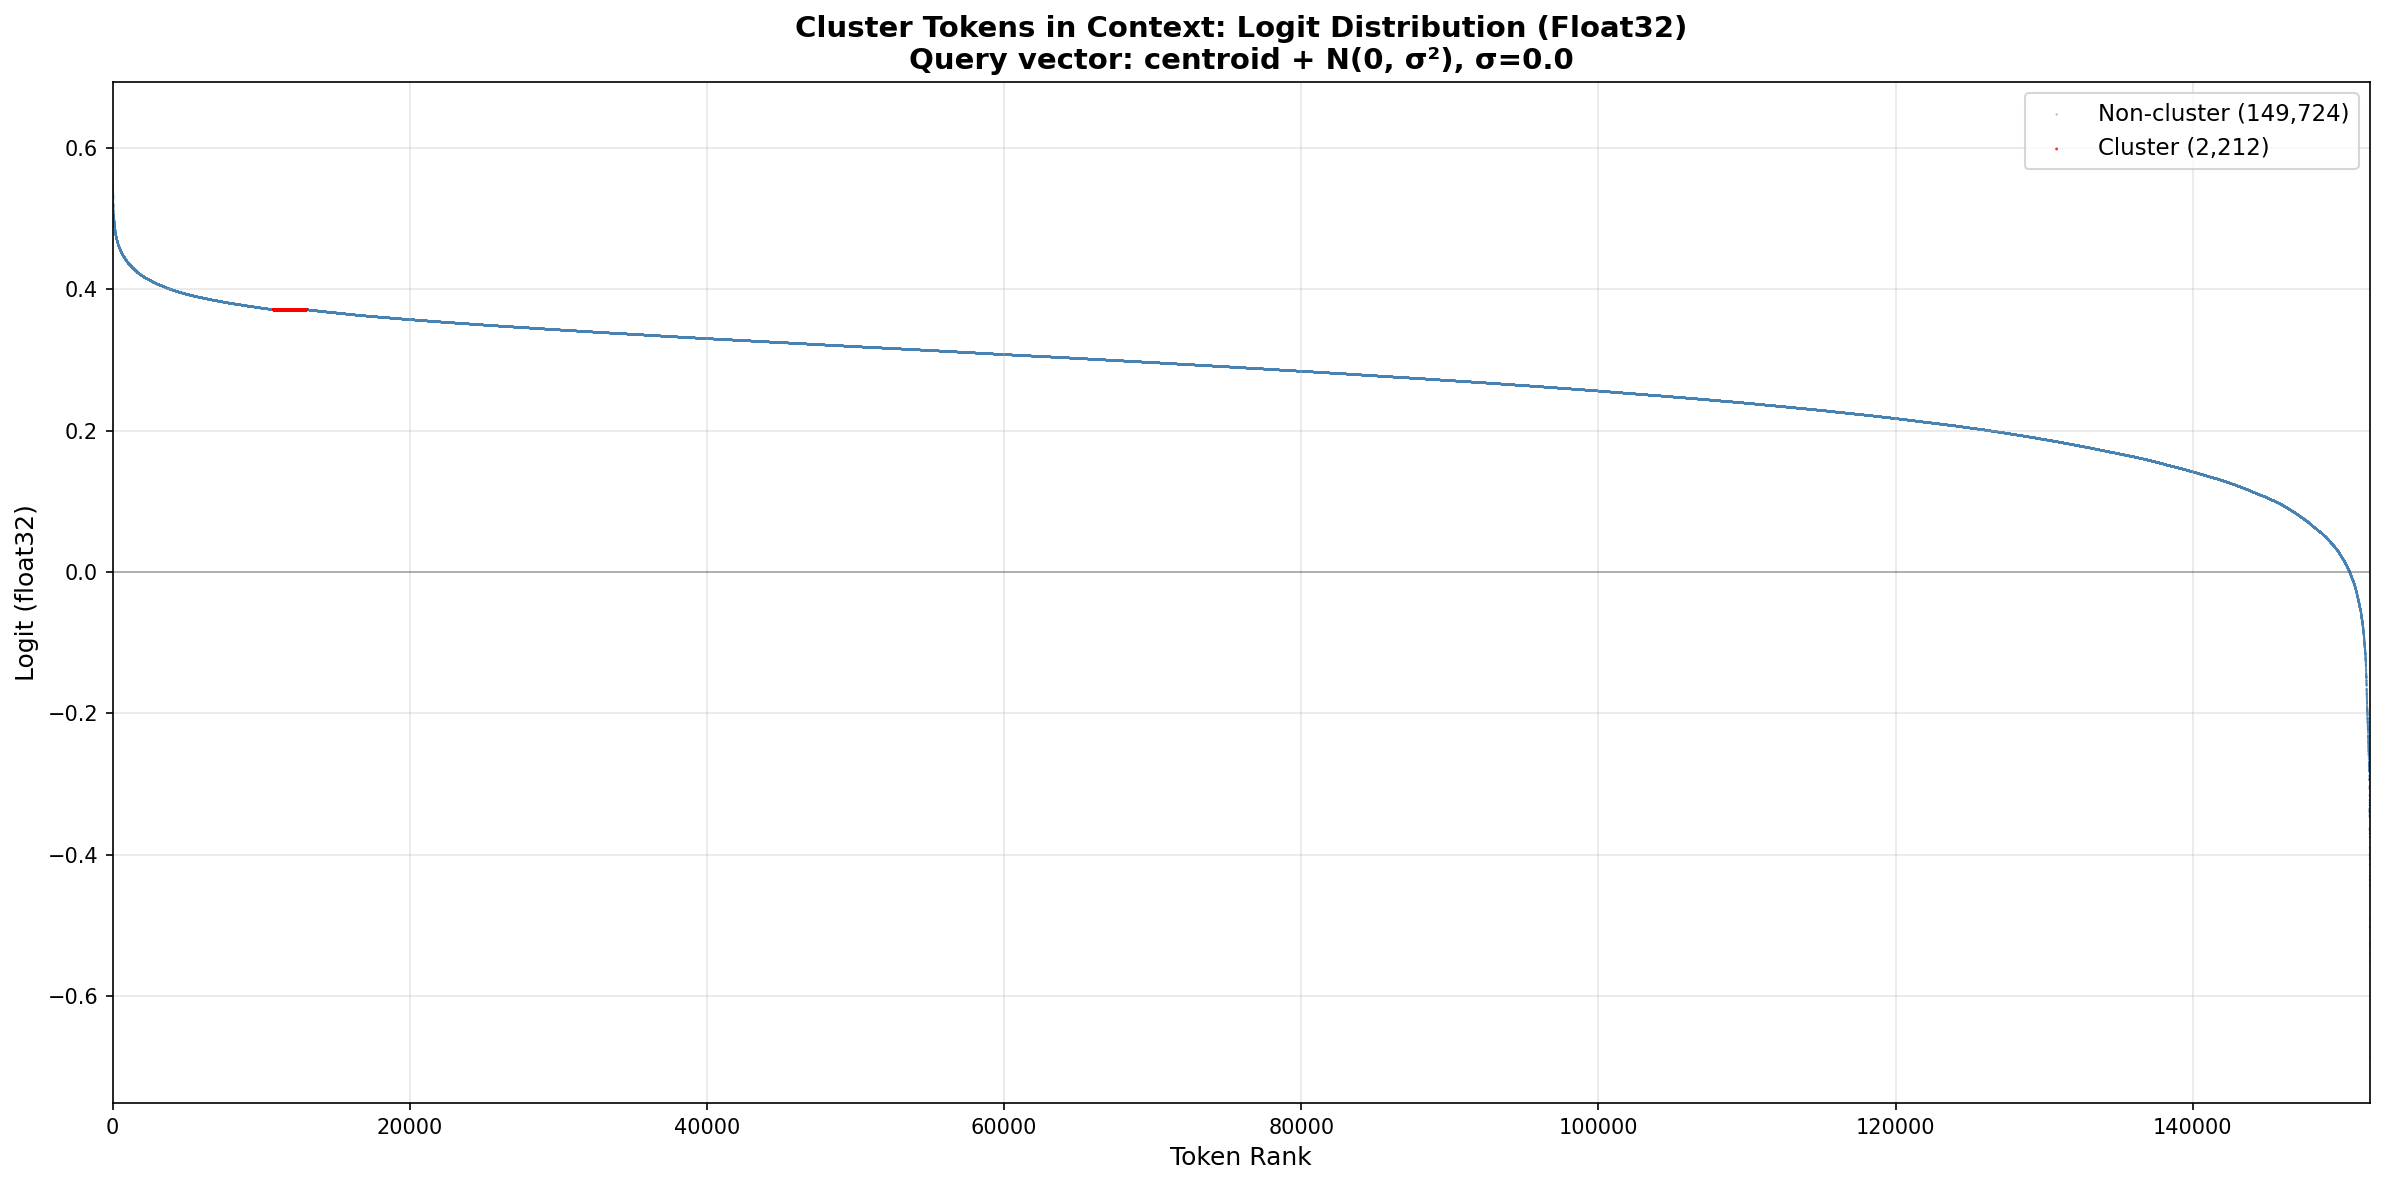

✓ Sorted logit plot complete


In [308]:
print(f"\nCreating sorted logit plot...\n")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE_SORTED, dpi=DPI)

# Plot non-cluster tokens (background)
ax.scatter(non_cluster_ranks, 
           non_cluster_logits_sorted,
           s=1.0, 
           alpha=0.6,
           color='steelblue',
           label=f'Non-cluster ({len(non_cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Plot cluster tokens (foreground)
ax.scatter(cluster_ranks, 
           cluster_logits_sorted,
           s=2.0, 
           alpha=0.8,
           color='red',
           label=f'Cluster ({len(cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_xlabel('Token Rank', fontsize=12)
ax.set_ylabel('Logit (float32)', fontsize=12)
ax.set_title(f'Cluster Tokens in Context: Logit Distribution (Float32)\n' +
             f'Query vector: centroid + N(0, σ²), σ={SIGMA}',
             fontsize=14, fontweight='bold')
ax.set_xlim(0, N)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print(f"✓ Sorted logit plot complete")

## Visualization 2: Logit Histogram (All Tokens, with Zoom)


Creating logit histogram...

Histogram zoom enabled:
  X range: [0.370915, 0.370918]
  Visible tokens: 2,205 / 151,936 (1.45%)


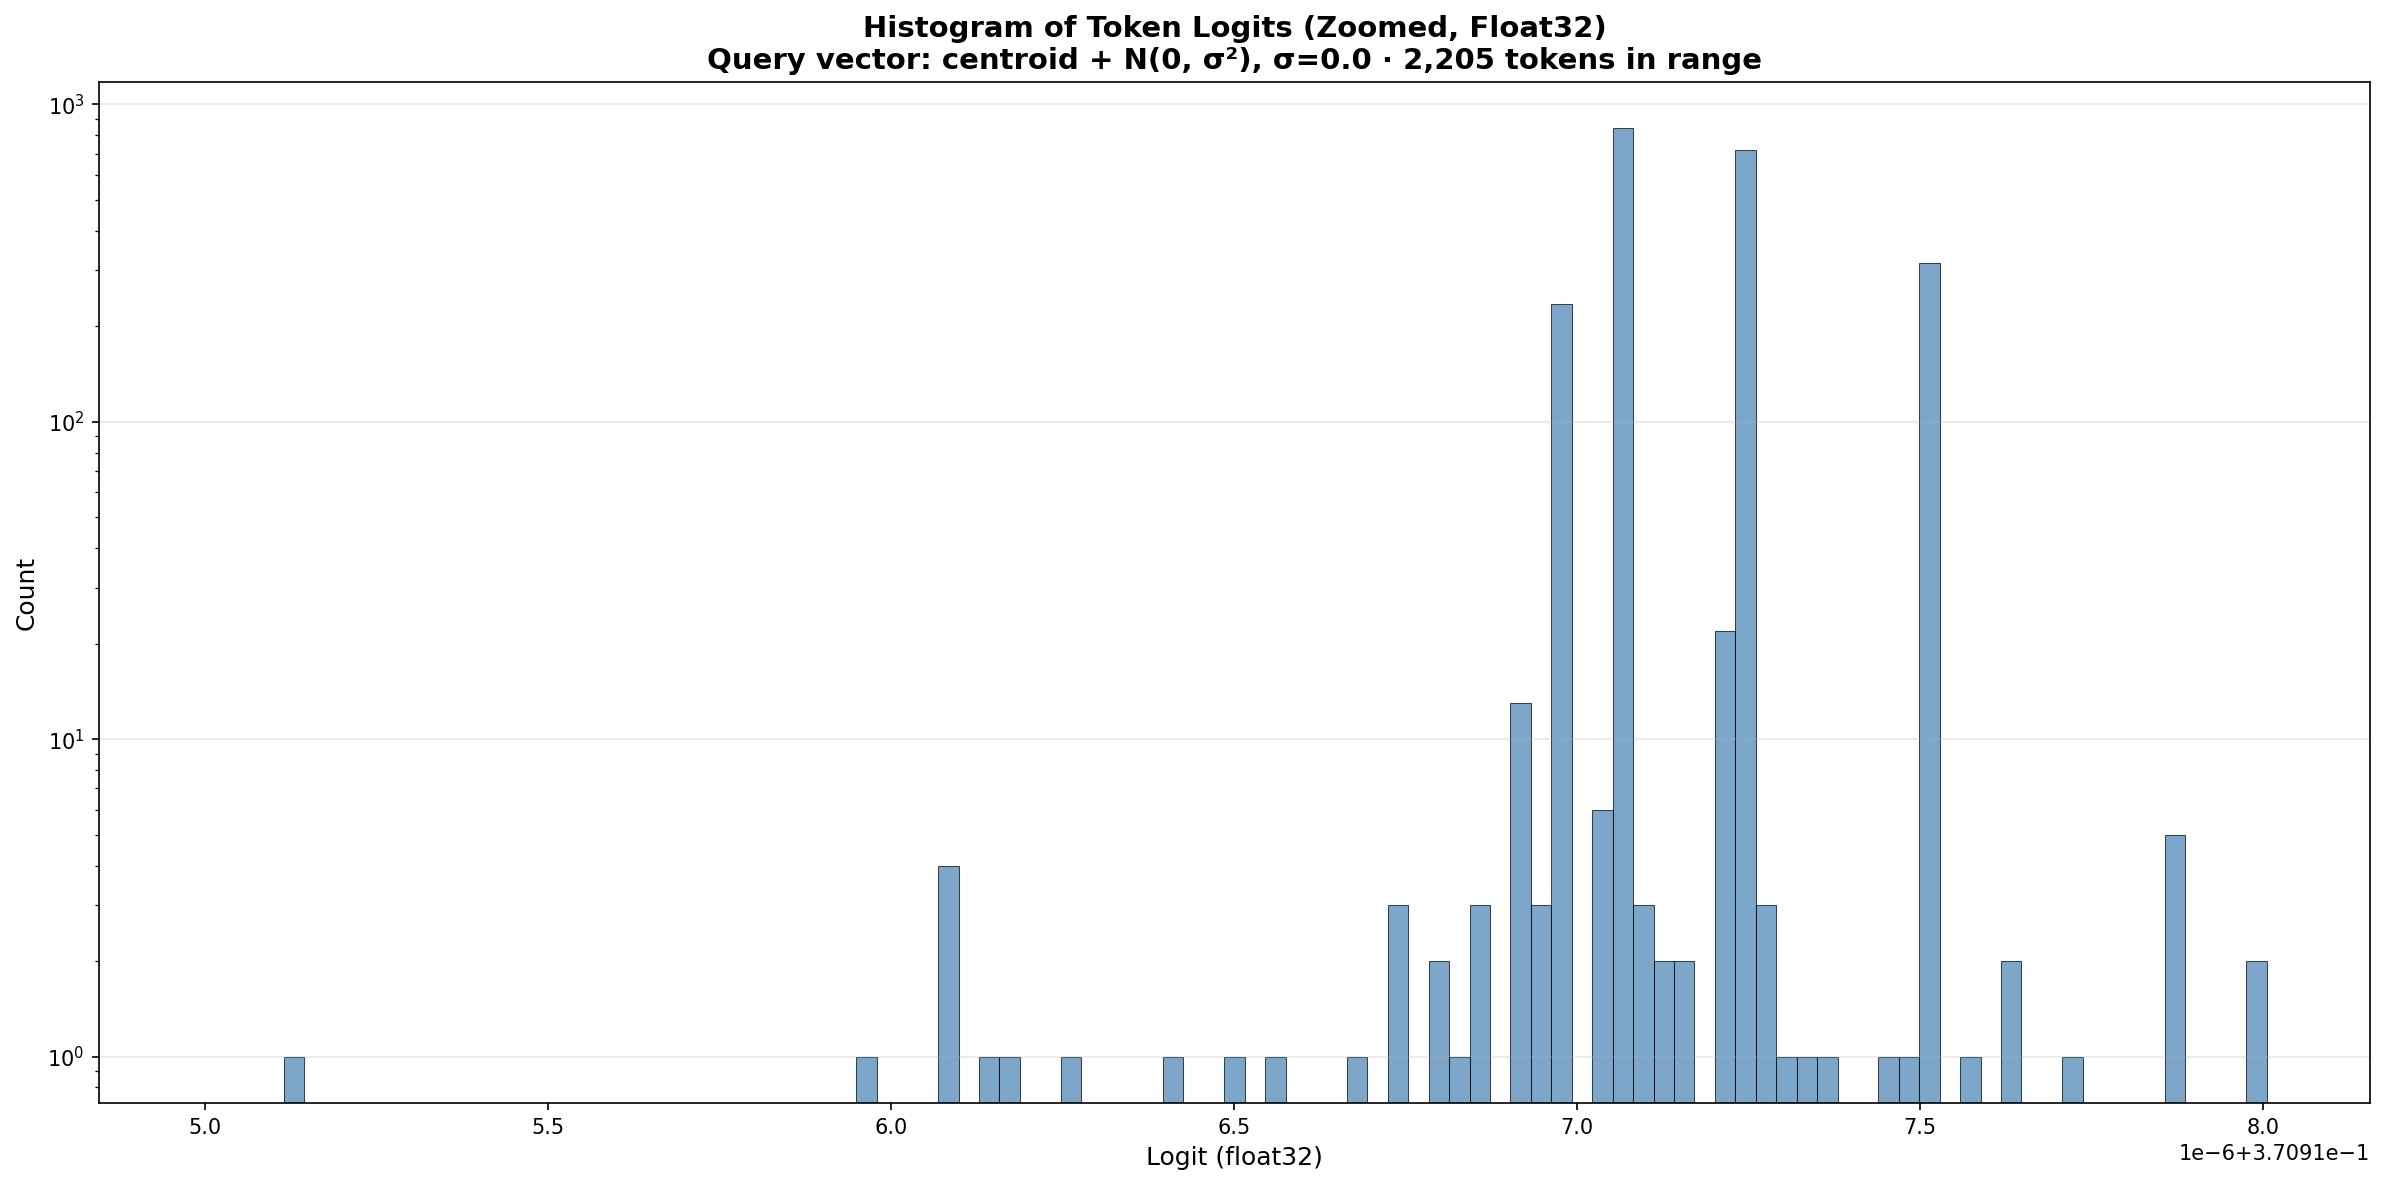


✓ Histogram complete

Histogram statistics:
  Bins: 100
  Bin width: 0.0000000298
  Max bin count: 841
  Non-zero bins: 36/100


In [309]:
print(f"\nCreating logit histogram...\n")

# Get all logits as numpy
all_logits_np = logits.cpu().numpy()

# Determine histogram range
if HIST_X_MIN is not None and HIST_X_MAX is not None:
    # Zoom mode: filter to visible range BEFORE binning
    mask = (all_logits_np >= HIST_X_MIN) & (all_logits_np <= HIST_X_MAX)
    visible_logits = all_logits_np[mask]
    hist_range = (HIST_X_MIN, HIST_X_MAX)
    print(f"Histogram zoom enabled:")
    print(f"  X range: [{HIST_X_MIN}, {HIST_X_MAX}]")
    print(f"  Visible tokens: {len(visible_logits):,} / {N:,} ({100*len(visible_logits)/N:.2f}%)")
else:
    # Full range mode
    visible_logits = all_logits_np
    hist_range = (all_logits_np.min(), all_logits_np.max())
    print(f"Histogram full range:")
    print(f"  X range: [{hist_range[0]:.6f}, {hist_range[1]:.6f}]")
    print(f"  All {N:,} tokens visible")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE_HIST, dpi=DPI)

# Histogram of visible logits
counts, bins, patches = ax.hist(visible_logits, 
                                 bins=NUM_BINS,
                                 range=hist_range,
                                 color='steelblue', 
                                 alpha=0.7, 
                                 edgecolor='black', 
                                 linewidth=0.5)

# Formatting
ax.set_xlabel('Logit (float32)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

if HIST_X_MIN is not None and HIST_X_MAX is not None:
    title = f'Histogram of Token Logits (Zoomed, Float32)\n' + \
            f'Query vector: centroid + N(0, σ²), σ={SIGMA} · {len(visible_logits):,} tokens in range'
else:
    title = f'Histogram of Token Logits (Full Range, Float32)\n' + \
            f'Query vector: centroid + N(0, σ²), σ={SIGMA} · {N:,} tokens'

ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Histogram complete")
print(f"\nHistogram statistics:")
print(f"  Bins: {NUM_BINS}")
print(f"  Bin width: {(bins[1] - bins[0]):.10f}")
print(f"  Max bin count: {counts.max():.0f}")
print(f"  Non-zero bins: {(counts > 0).sum()}/{NUM_BINS}")

## Summary

This notebook tests whether the cluster's degeneracy is a **quantization artifact** or **true geometric degeneracy**.

**Comparing to 1.7e (bfloat16):**

At σ=0, pointing at cluster centroid:

| Metric | 1.7e (bfloat16) | 1.7f (float32) | Interpretation |
|--------|-----------------|----------------|----------------|
| Unique cluster logits | 1 | ? | If still 1 → geometric degeneracy |
| Cluster std | 0.0 | ? | If still 0 → embeddings identical |
| Histogram spikes | None (smooth) | ? | If spikes appear → quantization hid structure |
| Visible tokens (0.35-0.40) | 20,124 | ? | If much fewer → quantization created noise |

**Expected outcomes:**

**Scenario 1: True geometric degeneracy**
- Float32 shows 1 unique value (same as bfloat16)
- Histogram still smooth (no discrete peaks)
- Cluster embeddings are truly identical
- Degeneracy is NOT a quantization artifact

**Scenario 2: Quantization artifact**
- Float32 shows ~134 unique values (13 BH + 121 singletons)
- Histogram shows discrete spikes at populations 814, 704, 306, etc.
- bfloat16 was too coarse to resolve cluster structure
- Cluster has internal variation hidden by quantization

**Scenario 3: Hybrid (most likely)**
- Float32 shows some structure (>1 unique values) but still highly degenerate
- Histogram shows partial spikes (some black holes merged)
- Both quantization AND geometric degeneracy contribute
- Cluster has small internal variation amplified by quantization effects